# Result centre points

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import DataSetQuery
import datetime
import json
import MalardHelpers
import geopandas as gp
import numpy as np
from shapely.geometry import Point, Polygon, LineString
from pandas.io.json import json_normalize
import math
import pandas as pd


In [4]:
environmentName = 'DEV'
parentDsName = 'mtngla'
dataSet = 'ReadyData6'
runName='TestRun6-Serial'
region = 'HMA'

#Sets the URL of the Malard ServiceGateway.
query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataSet)
bbx = json.loads(bbx)
minX=bbx['gridCellMinX']
maxX=bbx['gridCellMaxX']
minY=bbx['gridCellMinY']
maxY=bbx['gridCellMaxY']
minT = datetime.datetime.utcfromtimestamp(bbx['minTime']/1000) # divide by 1000 because it is in milliseconds
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime']/1000)


In [5]:
stats=query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
print('Columns: ',dfStats.columns)

#create new stats: area and point ratio
dfStats['statistics.points_per_sqkm']=dfStats['statistics.result_total']/dfStats['statistics.glacierMaskArea']

#convert to geodataframe
crs = json.loads(query.getProjection(region))['proj4']

#geometry = [Point(xy) for xy in zip(dfStats['gridCell.minX'], dfStats['gridCell.minY'])]
geometry = []
for idx, line in dfStats.iterrows():
    minX,maxX=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
    minY,maxY=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
    geometry.append(Polygon([(minX,minY), (minX,maxY), (maxX,maxY), (maxX,minY), (minX,minY)]))
geoStats = gp.GeoDataFrame(dfStats, crs=crs, geometry=geometry)
#geoStats=geoStats.dropna()


Columns:  Index(['gridCell.minX', 'gridCell.minY', 'gridCell.size',
       'statistics.afterDebrisMask', 'statistics.afterGlacierMask',
       'statistics.debrisMaskArea', 'statistics.glacierMaskArea',
       'statistics.joined_data', 'statistics.result_avgX',
       'statistics.result_avgY', 'statistics.result_count_2010',
       'statistics.result_count_2011', 'statistics.result_count_2012',
       'statistics.result_count_2013', 'statistics.result_count_2014',
       'statistics.result_count_2015', 'statistics.result_count_2016',
       'statistics.result_count_2017', 'statistics.result_count_2018',
       'statistics.result_offsetX', 'statistics.result_offsetX_2010',
       'statistics.result_offsetX_2011', 'statistics.result_offsetX_2012',
       'statistics.result_offsetX_2013', 'statistics.result_offsetX_2014',
       'statistics.result_offsetX_2015', 'statistics.result_offsetX_2016',
       'statistics.result_offsetX_2017', 'statistics.result_offsetX_2018',
       'statistics.r

# Gridcell statistics mean

In [17]:
print('MEAN: ---------------------')
print(dfStats.mean())

MEAN: ---------------------
gridCell.minX                    -150777.202073
gridCell.minY                    -190673.575130
gridCell.size                     100000.000000
statistics.afterDebrisMask         16321.549223
statistics.afterGlacierMask        17115.461140
statistics.debrisMaskArea             51.746469
statistics.glacierMaskArea           478.877568
statistics.joined_data            850034.445596
statistics.result_avgX           -101008.760006
statistics.result_avgY           -139788.209318
statistics.result_count_2010         624.398964
statistics.result_count_2011        1917.031088
statistics.result_count_2012        2037.227979
statistics.result_count_2013        2032.606218
statistics.result_count_2014        2003.751295
statistics.result_count_2015        2020.507772
statistics.result_count_2016        1982.072539
statistics.result_count_2017        1899.580311
statistics.result_count_2018        1804.373057
statistics.result_offsetX           -231.557933
statistics.r

In [6]:
# read glaciers
pathM = "/data/puma1/scratch/mtngla/masks/himalayas/glacier-outlines/13_14_15_rgi60_Himalayas_mask.shp"
glaciers = gp.read_file(pathM)

In [7]:
# convert center points to geo points
crs = json.loads(query.getProjection(region))['proj4']

def toGeoData(data):
    # Convert points to geometries
    geometry = [Point(xy) for xy in zip(data['statistics.result_avgX'], data['statistics.result_avgY'])]
    gData = gp.GeoDataFrame(data, crs=crs, geometry=geometry)
    return gData

centerPoints = toGeoData(geoStats.copy())

# Gridcells with centre points displayed

<IPython.core.display.Javascript object>


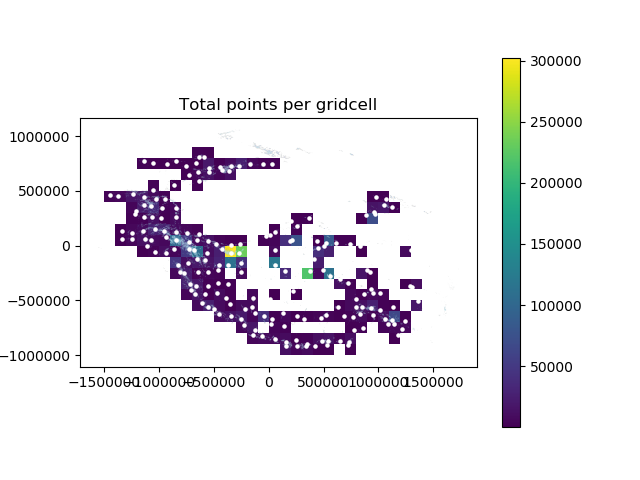

In [8]:
base = geoStats.plot(column='statistics.result_total', markersize=5, legend=True)
glaciers.plot(ax=base,facecolor='lightblue')
centerPoints.plot(ax=base, color='white', markersize=5)

base.set_title('Total points per gridcell')
plt.show()

In [8]:
#fig, axs = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True, tight_layout=True)
#ax0, ax1 = axs.flatten()

# Average changes between two years

<IPython.core.display.Javascript object>


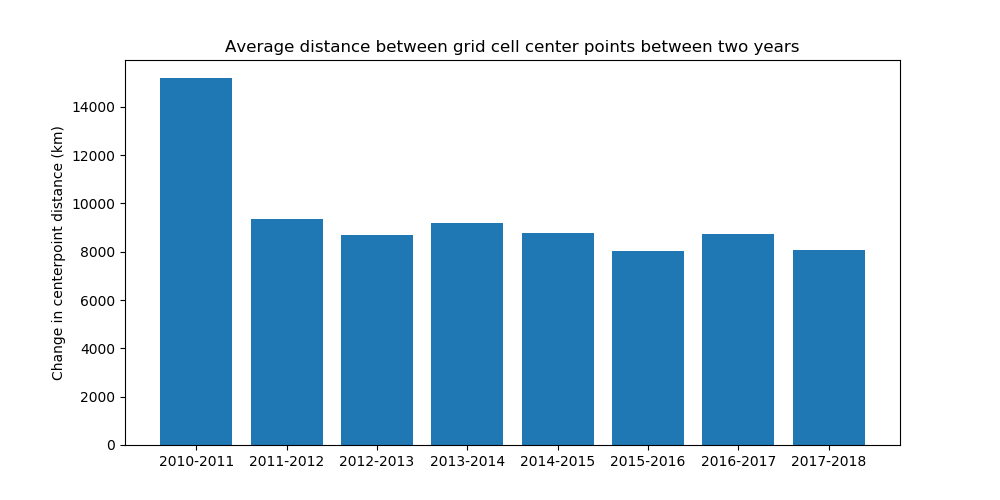

<BarContainer object of 8 artists>

In [10]:
# average changes between two years
changesX = ['2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018']

min_X,min_Y=geoStats['gridCell.minX'],geoStats['gridCell.minY']
size = geoStats['gridCell.size']
geoStats['gridCell.centerX'] = min_X+(size/2)
geoStats['gridCell.centerY'] = min_Y+(size/2)

changes=[]
years=[x for x in range(minT.year, maxT.year)]
for year in years:
    xdist = (abs(geoStats['statistics.result_offsetX_%s'%year]-geoStats['statistics.result_offsetX_%s'%(year+1)]))
    ydist = (abs(geoStats['statistics.result_offsetY_%s'%year]-geoStats['statistics.result_offsetY_%s'%(year+1)]))
    dist = (xdist**2 + ydist**2)**(0.5)
    changes.append(dist)

means = [change.mean() for change in changes]
plt.figure(figsize=(10,5))

plt.title('Average distance between grid cell center points between two years')
plt.ylabel('Change in centerpoint distance (km)')
plt.bar(changesX, means)

# HISTOGRAM DISTRIBUTION OF DISTANCE CHANGE BETWEEN TWO YEARS

<IPython.core.display.Javascript object>


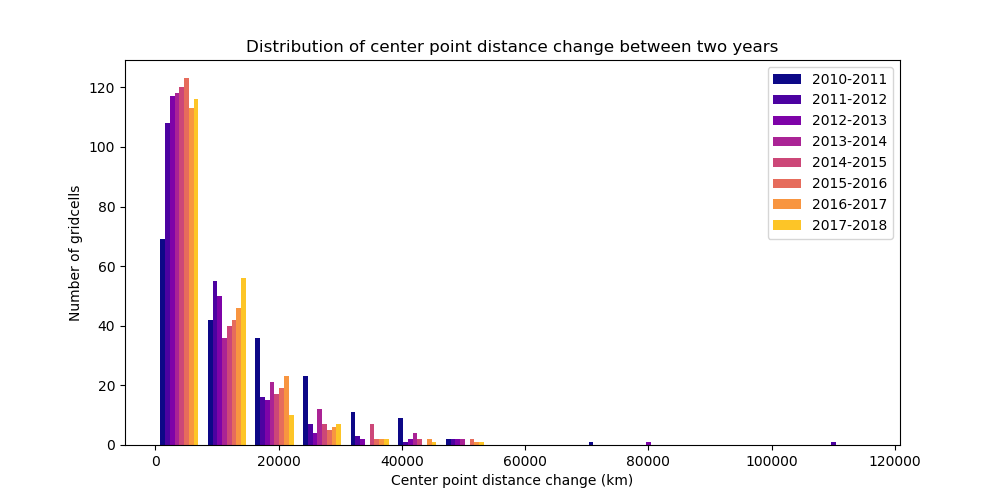

In [11]:
#HISTOGRAM DISTRIBUTION OF DISTANCE CHANGE BETTWEEN TWO YEARS
plt.figure(figsize=(10,5))
plt.title('Distribution of center point distance change between two years')
plt.ylabel('Number of gridcells')
plt.xlabel('Center point distance change (km)')
bins = 15
NUM_COLORS = 8
cm = plt.get_cmap('plasma')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax=plt.hist([changes[0], changes[1], changes[2], changes[3], changes[4], changes[5], changes[6], changes[7]],  bins, label=changesX, color=colors)

plt.legend(loc='upper right')
plt.show()

# Average distance to mean (over all years) center point

<IPython.core.display.Javascript object>


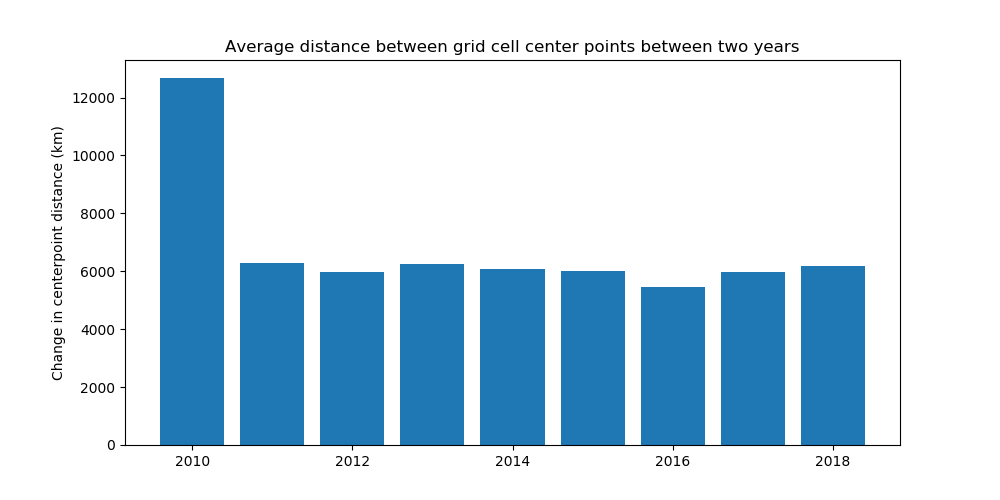

<BarContainer object of 9 artists>

In [12]:
# Average distance to mean (over all years) center point

changesMean = []
min_X,min_Y=geoStats['gridCell.minX'],geoStats['gridCell.minY']
size = geoStats['gridCell.size']
geoStats['gridCell.centerX'] = min_X+(size/2)
geoStats['gridCell.centerY'] = min_Y+(size/2)

years=[x for x in range(minT.year, maxT.year+1)]
for year in years:
    xdist = (abs(geoStats['statistics.result_offsetX_%s'%year]-geoStats['statistics.result_offsetX']))
    ydist = (abs(geoStats['statistics.result_offsetY_%s'%year]-geoStats['statistics.result_offsetY']))
    dist = (xdist**2 + ydist**2)**(0.5)
    changesMean.append(dist)

means = [change.mean() for change in changesMean]
plt.figure(figsize=(10,5))

plt.title('Average distance between grid cell center points between two years')
plt.ylabel('Change in centerpoint distance (km)')
plt.bar(years, means)

# HISTOGRAM DISTRIBUTION OF DISTANCE TO MEAN CENTER POINT EVERY YEAR

<IPython.core.display.Javascript object>


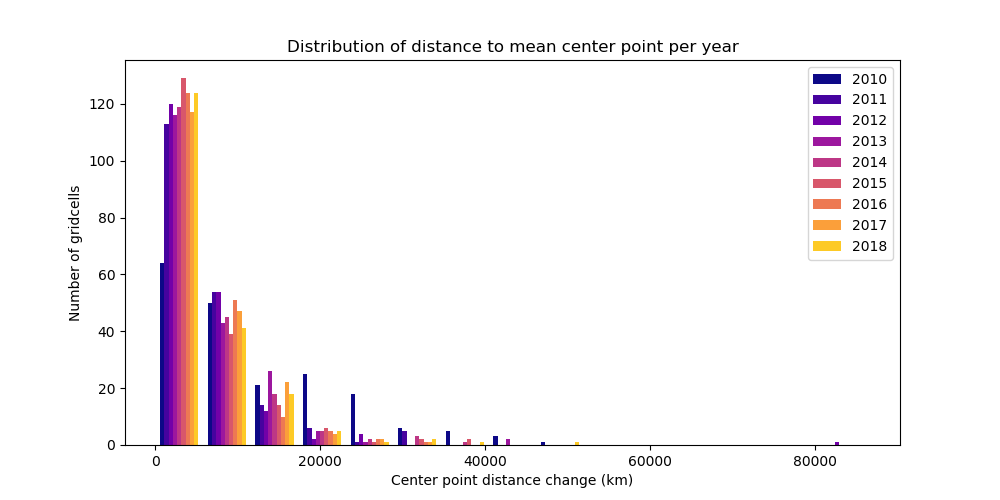

In [13]:
# HISTOGRAM DISTRIBUTION OF DISTANCE TO MEAN CENTER POINT EVERY YEAR
plt.figure(figsize=(10,5))
plt.title('Distribution of distance to mean center point per year')
plt.ylabel('Number of gridcells')
plt.xlabel('Center point distance change (km)')
bins = 15
NUM_COLORS = 9
cm = plt.get_cmap('plasma')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax=plt.hist([changesMean[0], changesMean[1], changesMean[2], changesMean[3], changesMean[4], changesMean[5], changesMean[6], changesMean[7], changesMean[8]],  bins, label=years, color=colors)

plt.legend(loc='upper right')
plt.show()

In [15]:
# compute gridcell center points every year
cpoints_year=[]
years=[x for x in range(minT.year, maxT.year+1)]
for year in years:
    avgX = geoStats['gridCell.centerX']+ geoStats['statistics.result_offsetX_%s'%year]
    avgY = geoStats['gridCell.centerY']+ geoStats['statistics.result_offsetY_%s'%year]
    geometry = [Point(xy) for xy in zip(avgX, avgY)]
    cpoints_year.append(gp.GeoDataFrame([], crs=crs, geometry=geometry))
# lines
lines=[]
for idx, row in geoStats.iterrows():
    line = []
    for yr in range(len(years)):
        line.append(cpoints_year[yr].iloc[idx,0])
    lines.append(LineString(line))
lines = gp.GeoDataFrame([], crs=crs, geometry=lines)

# Center points plotted for every year

<IPython.core.display.Javascript object>


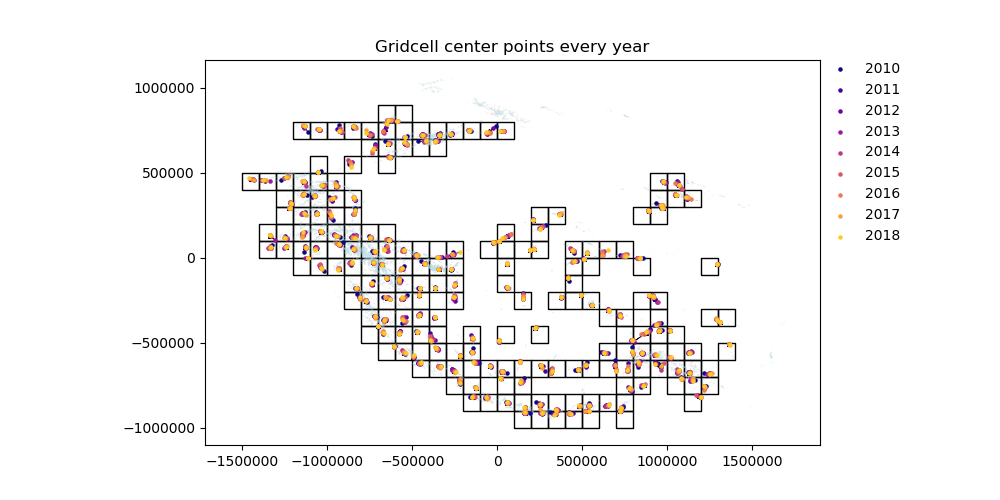

In [21]:
# plot Gridcell center points every year
fig, base = plt.subplots(figsize=(10, 5))
NUM_COLORS = 9
cm = plt.get_cmap('plasma')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
geoStats.plot(ax=base, markersize=5, facecolor='None', edgecolor='black', linewidth=1)
glaciers.plot(ax=base,facecolor='lightblue')
lines.plot(ax=base, edgecolor='black', linewidth=0.5, linestyle='-')
# average plot center points
centerPoints.plot(ax=base, color='black', markersize=7, marker='^')
for i in range(len(years)):
    cpoints_year[i].plot(zorder=10,ax=base, color=colors[i], markersize=5, label=years[i])

plt.legend(loc='upper left', bbox_to_anchor= (1.0, 1.01), ncol=1, 
            borderaxespad=0, frameon=False)
base.set_title('Gridcell center points every year')
plt.show()

In [23]:
years=[x for x in range(minT.year, maxT.year+1)]
for idx in range(len(years)):
    geoStats['statistics.distance_to_mean_%s'%years[idx]]=changesMean[idx]
   

# Gridecell stats: Mean 

In [24]:
pd.options.display.float_format = '{:20,.2f}'.format

print('MEAN: ---------------------')
print(geoStats.mean())

MEAN: ---------------------
gridCell.minX                               -150,777.20
gridCell.minY                               -190,673.58
gridCell.size                                100,000.00
statistics.afterDebrisMask                    16,321.55
statistics.afterGlacierMask                   17,115.46
statistics.debrisMaskArea                         51.75
statistics.glacierMaskArea                       478.88
statistics.joined_data                       850,034.45
statistics.result_avgX                      -101,008.76
statistics.result_avgY                      -139,788.21
statistics.result_count_2010                     624.40
statistics.result_count_2011                   1,917.03
statistics.result_count_2012                   2,037.23
statistics.result_count_2013                   2,032.61
statistics.result_count_2014                   2,003.75
statistics.result_count_2015                   2,020.51
statistics.result_count_2016                   1,982.07
statistics.result_co